In [1]:
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import metricas_plots

In [17]:
importlib.reload(metricas_plots)
from metricas_plots import PlotsMetricas
p = PlotsMetricas()

In [3]:
larguras = [t for t in p.targets[:4]]
linhas = [l.replace('ew', 'flux') for l in larguras]

## Análise Exploratória

In [4]:
dados = pd.read_csv("dados/ariel_limpo_log10.csv.gz", compression="gzip")
print(dados.shape)

(125819, 22)


In [5]:
print(dados.columns)

Index(['fileid', 'RA', 'Dec', 'z', 'atflux', 'atmass', 'aZflux', 'aZmass',
       'mass', 'Av', 'nii_6584_flux', 'halpha_flux', 'oiii_5007_flux',
       'hbeta_flux', 'nii_6584_ew', 'halpha_ew', 'oiii_5007_ew', 'hbeta_ew',
       'nii_halpha_ew', 'oiii_hbeta_ew', 'nii_halpha_flux', 'oiii_hbeta_flux'],
      dtype='object')


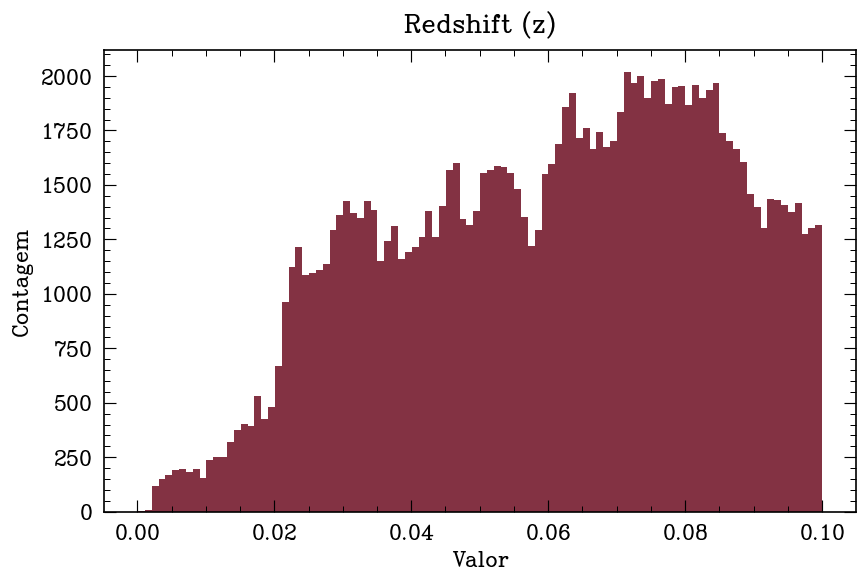

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5*p.phi, 5))
p.histogram_v(dados["z"], "Redshift (z)", ax, cor="#833243")
plt.show()

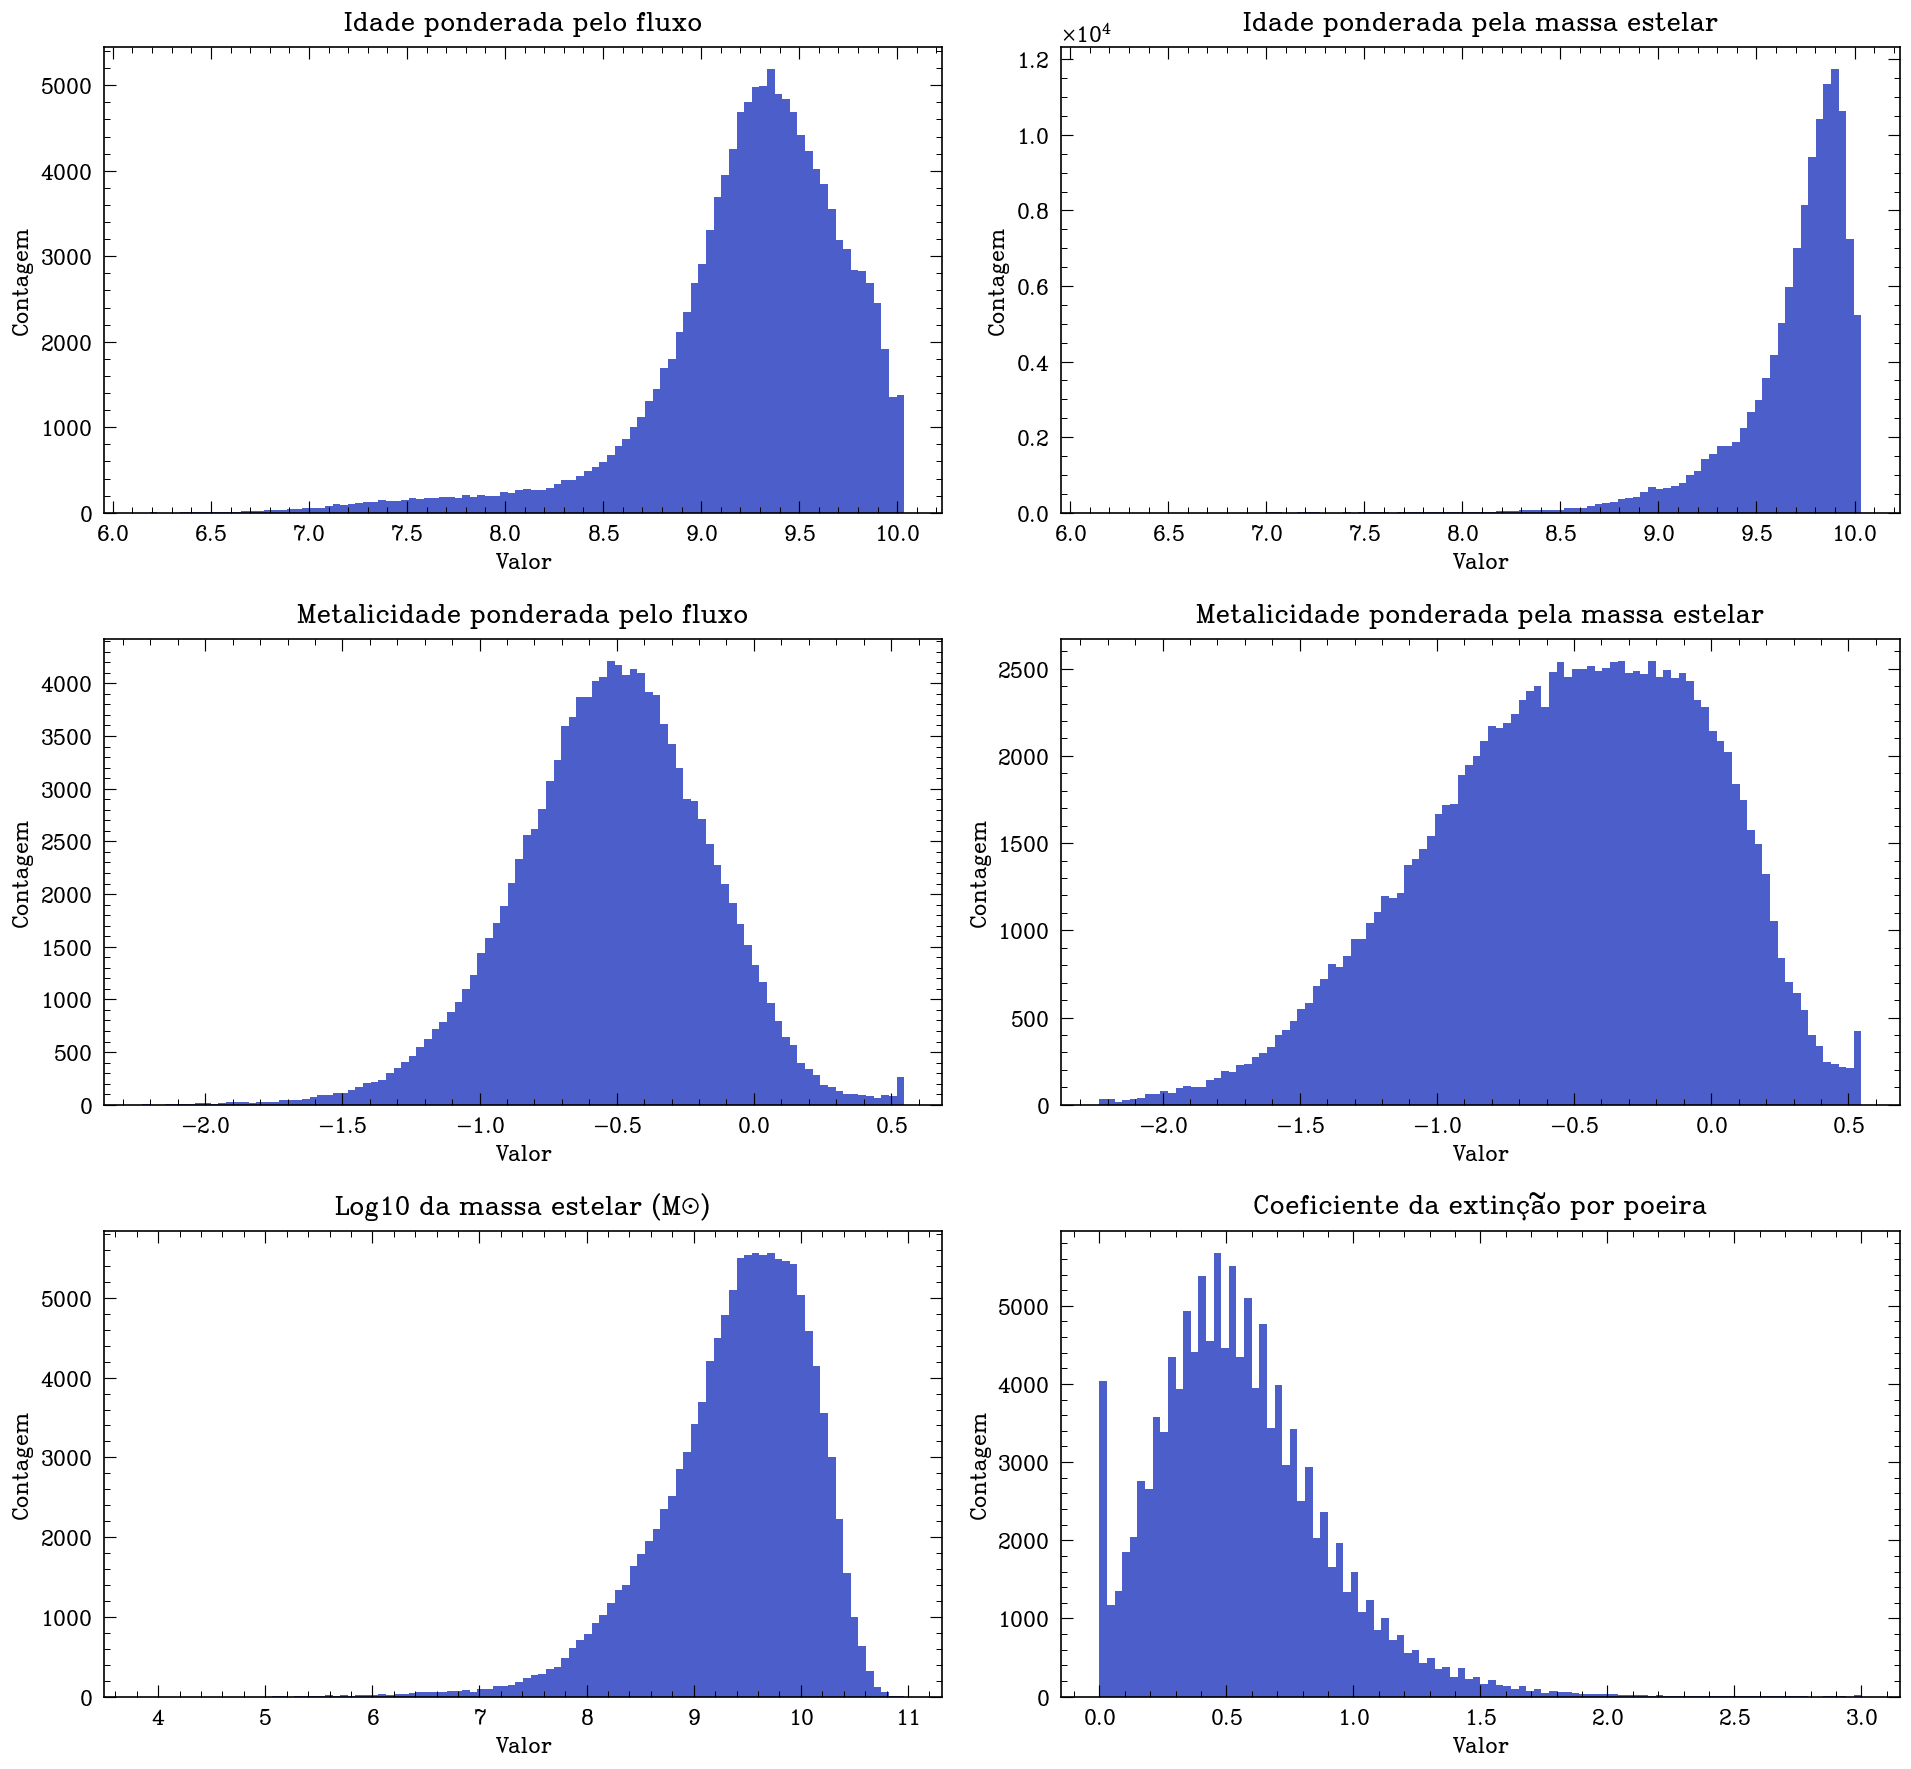

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(10*p.phi, 15))
p.histogram_v(dados["atflux"], "Idade ponderada pelo fluxo", axs[0][0], cor="#4B5EC9")
p.histogram_v(dados["atmass"], "Idade ponderada pela massa estelar", axs[0][1], cor="#4B5EC9")
p.histogram_v(dados["aZflux"], "Metalicidade ponderada pelo fluxo", axs[1][0], cor="#4B5EC9")
p.histogram_v(dados["aZmass"], "Metalicidade ponderada pela massa estelar", axs[1][1], cor="#4B5EC9")
p.histogram_v(dados["mass"], 'Log10 da massa estelar (M☉)', axs[2][0], cor="#4B5EC9")
p.histogram_v(dados["Av"], 'Coeficiente da extinção por poeira', axs[2][1], cor="#4B5EC9")
plt.tight_layout()
plt.show()

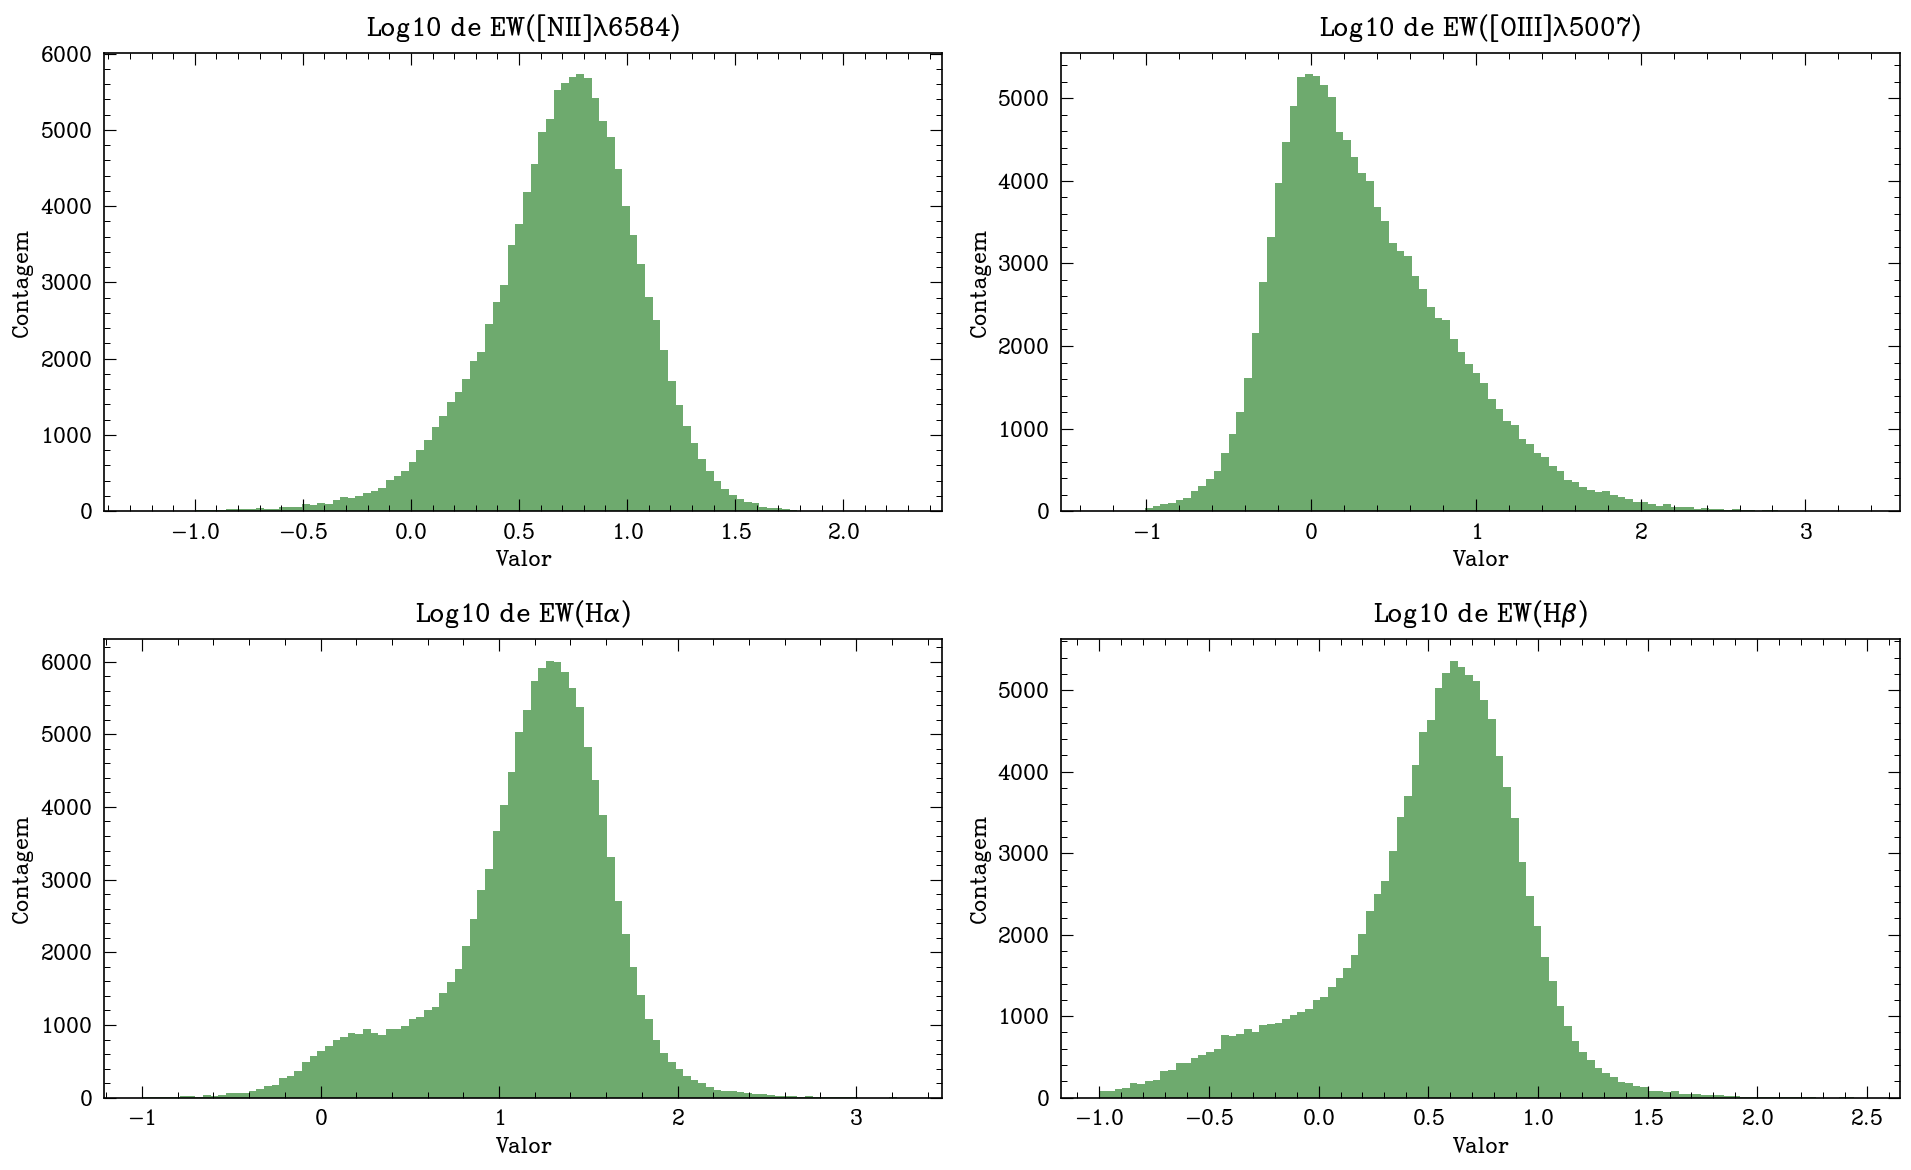

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10*p.phi, 10))
p.histogram_v(dados["nii_6584_ew"], r"Log10 de EW([NII]$\lambda6584$)", axs[0][0], cor="#6EAA6E")
p.histogram_v(dados["oiii_5007_ew"], r"Log10 de EW([OIII]$\lambda5007$)", axs[0][1], cor="#6EAA6E")
p.histogram_v(dados["halpha_ew"], r"Log10 de EW(H$\alpha$)", axs[1][0], cor="#6EAA6E")
p.histogram_v(dados["hbeta_ew"], r"Log10 de EW(H$\beta$)", axs[1][1], cor="#6EAA6E")
plt.tight_layout()
plt.show()

## Correlações

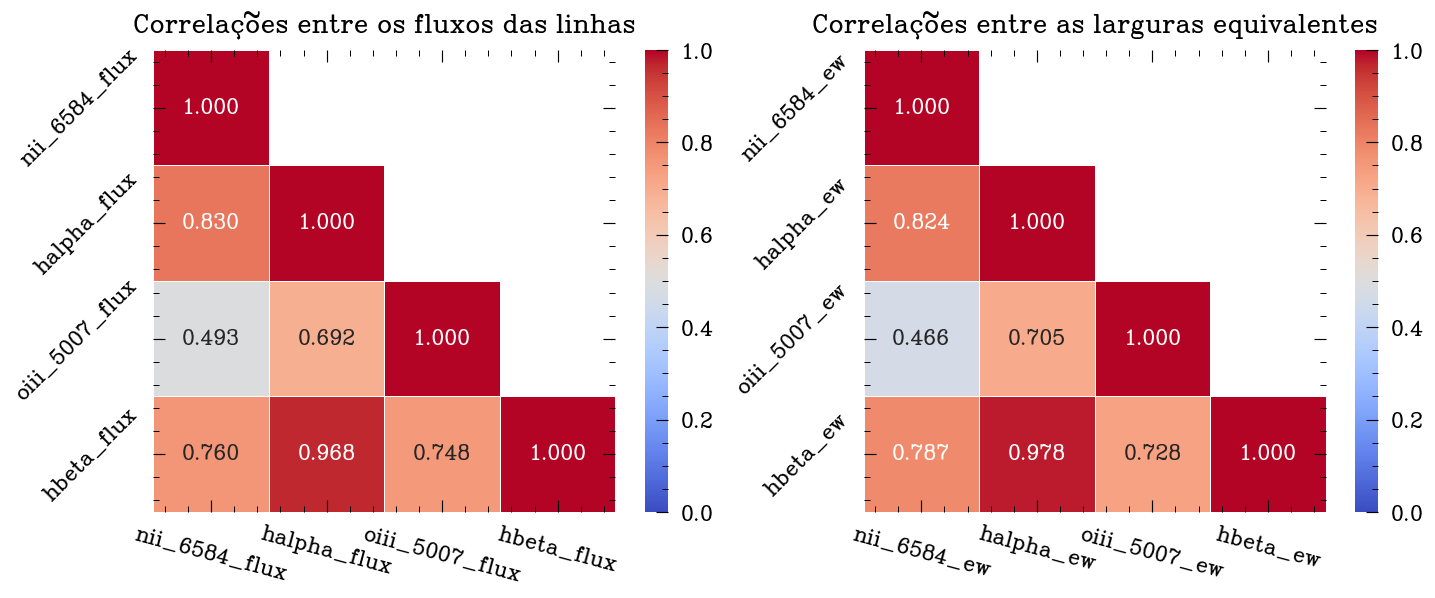

In [9]:
corr1 = dados.loc[:, linhas].corr()
corr2 = dados.loc[:, larguras].corr()
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
p.plot_corr(corr1, axs[0], linhas, 'Correlações entre os fluxos das linhas', type='inf')
p.plot_corr(corr2, axs[1], larguras, 'Correlações entre as larguras equivalentes', type='inf')
plt.show()

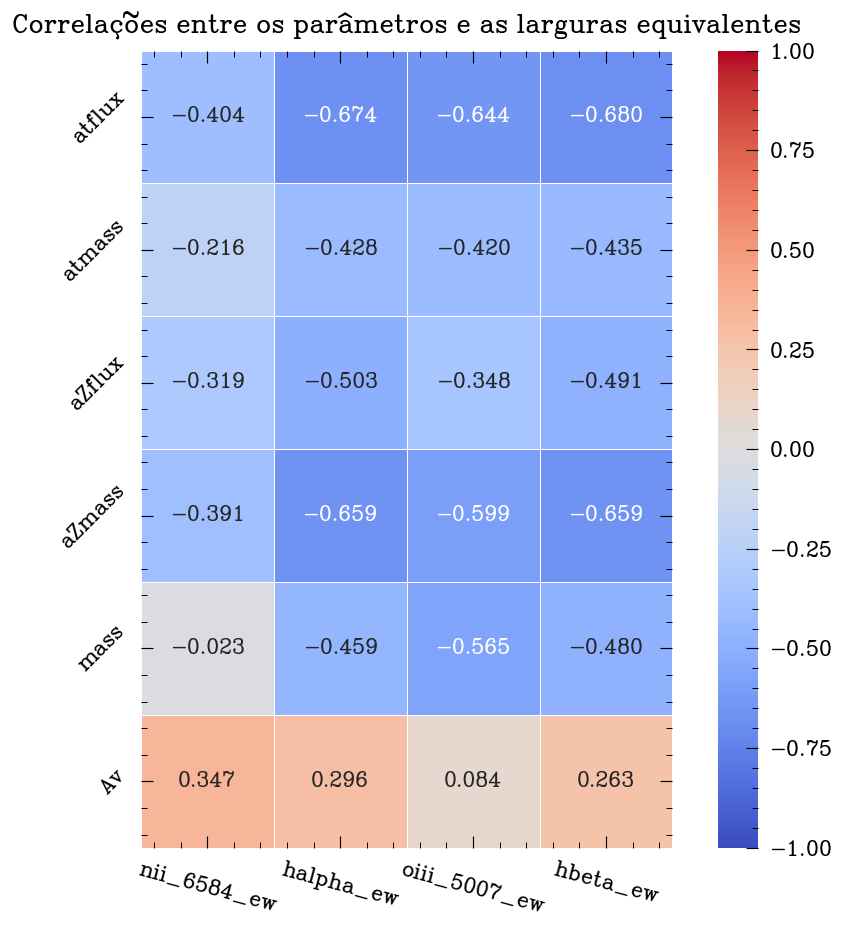

In [10]:
corr3 = dados.loc[:,  p.features + larguras].corr()
corr3.drop(index=larguras, columns= p.features, inplace=True)
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
p.plot_corr(corr3, axs, vmin=-1, title='Correlações entre os parâmetros e as larguras equivalentes')
fig.tight_layout()
fig.show()

Correlação de Pearson entre bins e médias: -0.6340


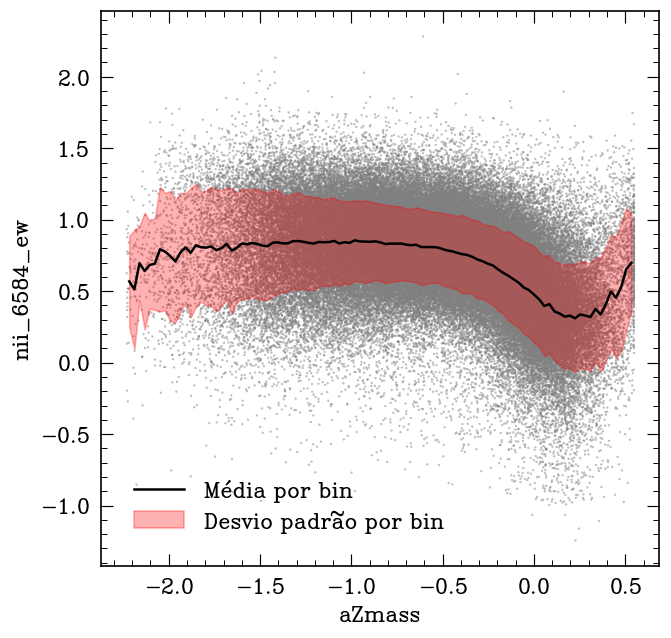

In [11]:
from scipy import stats
import numpy as np

def binned_statistic(x, y, nbins=100):
    bins = np.linspace(x.min(), x.max(), nbins)
    medias, bin_edges, _ = stats.binned_statistic(x, y, statistic='mean', bins=bins)
    stds, _, _ = stats.binned_statistic(x, y, statistic='std', bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    corr_value, _ = stats.pearsonr(bin_centers, medias) # segundo resultado é o p-value
    return bin_centers, medias, stds, corr_value

col_x = 'aZmass'; col_y = 'nii_6584_ew'
centers, medias, stds, corr = binned_statistic(dados[col_x], dados[col_y])
print(f"Correlação de Pearson entre bins e médias: {corr:.4f}")
plt.scatter(dados[col_x], dados[col_y], alpha=0.5, color='gray', s=2, edgecolors='none')
plt.plot(centers, medias, 'k-', linewidth=1.5, label="Média por bin")
plt.fill_between(centers, medias - stds, medias + stds, alpha=0.3, color='red', label="Desvio padrão por bin")
plt.xlabel(col_x)
plt.ylabel(col_y)
plt.legend()
plt.show()

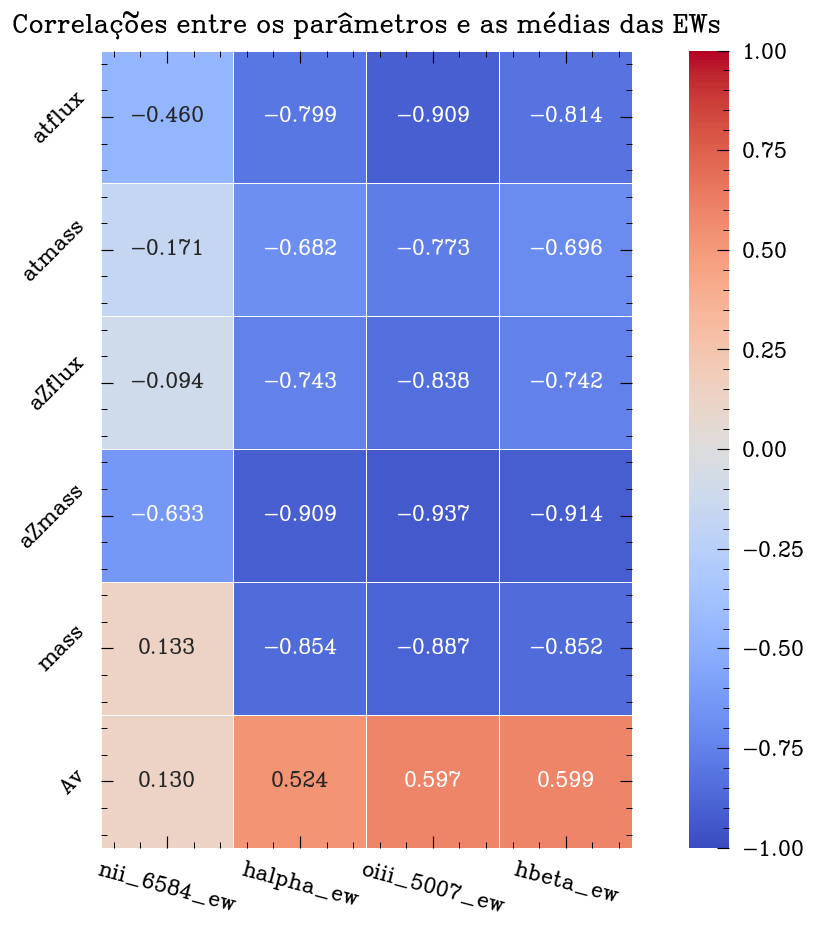

In [12]:
# Retorna um DataFrame com a correlação de Pearson entre os bins.
def calculate_binned_correlations(dados, features, larguras, nbins=100):
    correlations = []
    for feature in features:
        row = {}
        for largura in larguras:
            x = dados[feature].values
            y = dados[largura].values
            if len(x) > 10:  # Precisa de dados suficientes
                bins = np.linspace(x.min(), x.max(), nbins)
                medias, bin_edges, _ = stats.binned_statistic(x, y, statistic='mean', bins=bins)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                valid = ~np.isnan(medias)
                if valid.sum() > 2:
                    corr_value, _ = stats.pearsonr(bin_centers[valid], medias[valid])
                else:
                    corr_value = np.nan
            else:
                corr_value = np.nan
            row[largura] = corr_value
        correlations.append(row)
    corr_binned = pd.DataFrame(correlations, index=features)
    return corr_binned

# Calcular e plotar as correlações
corr_binned = calculate_binned_correlations(dados, p.features, larguras, 200)
fig, ax = plt.subplots(figsize=(10, 8))
p.plot_corr(corr_binned, ax, vmin=-1, title='Correlações entre os parâmetros e as médias das EWs')
plt.tight_layout()
plt.show()

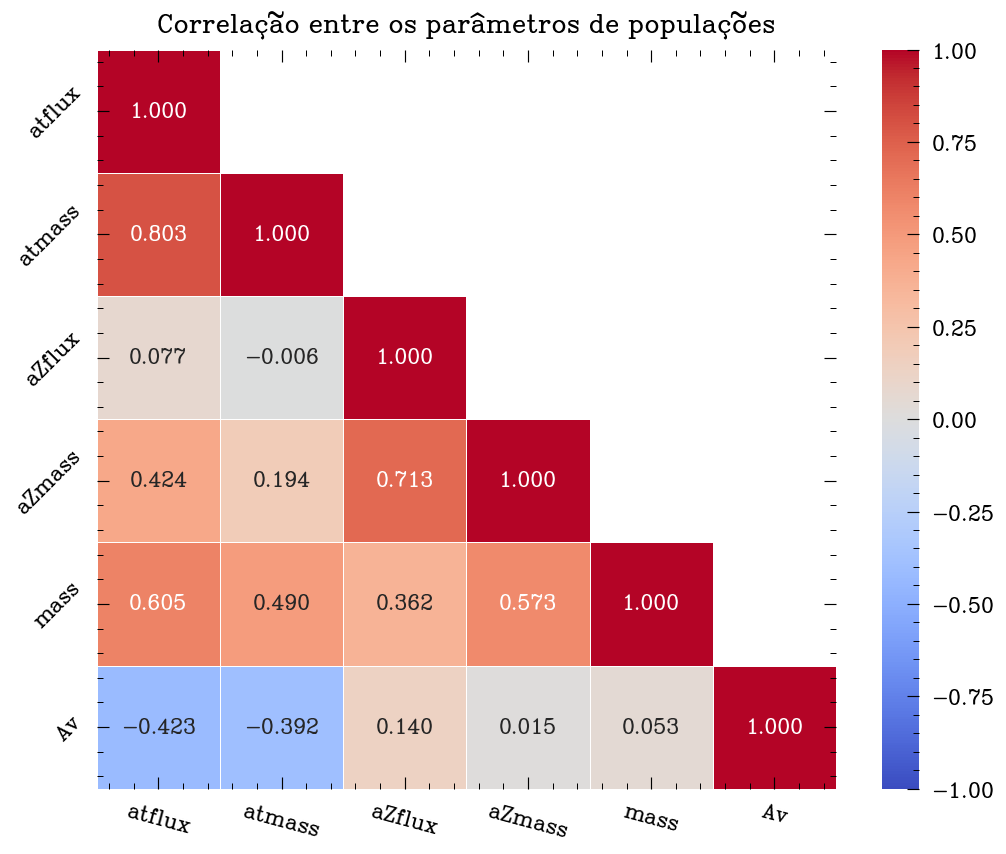

In [13]:
# Correlações entre os parâmetros
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
p.plot_corr(dados[p.features].corr(), ax, vmin=-1, title='Correlação entre os parâmetros de populações', type='inf')
fig.show()

## Diagramas de diagnóstico

In [14]:
M = int(dados.shape[0] * 0.20) # 20% dos dados
dados_ = dados.sample(n=M, random_state=4321).reset_index().copy()
print(dados_.shape)

(25163, 23)


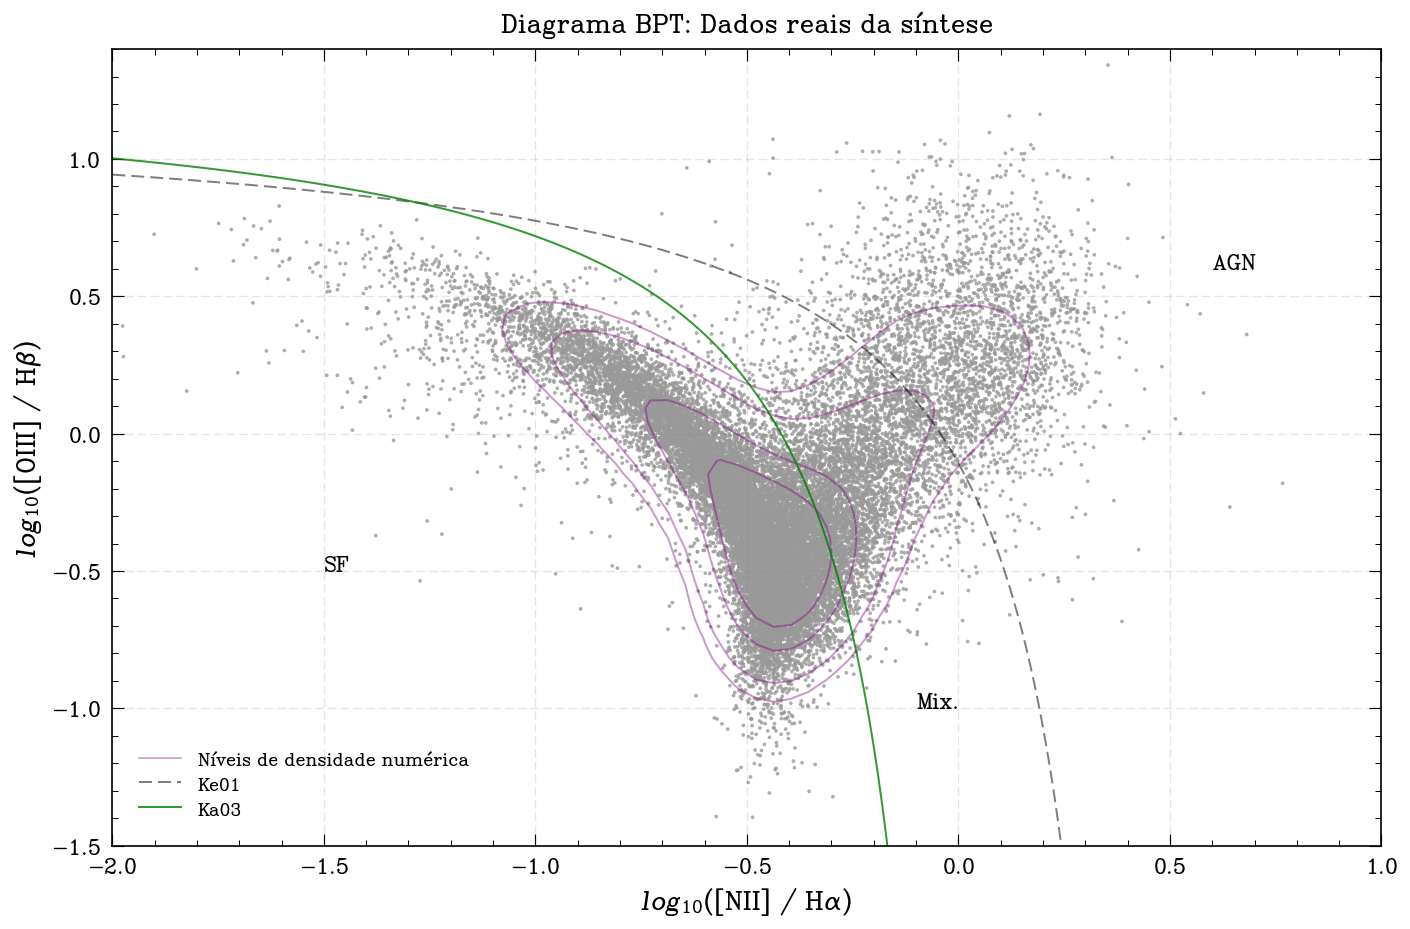

In [18]:
p.show_bpt(dados_)

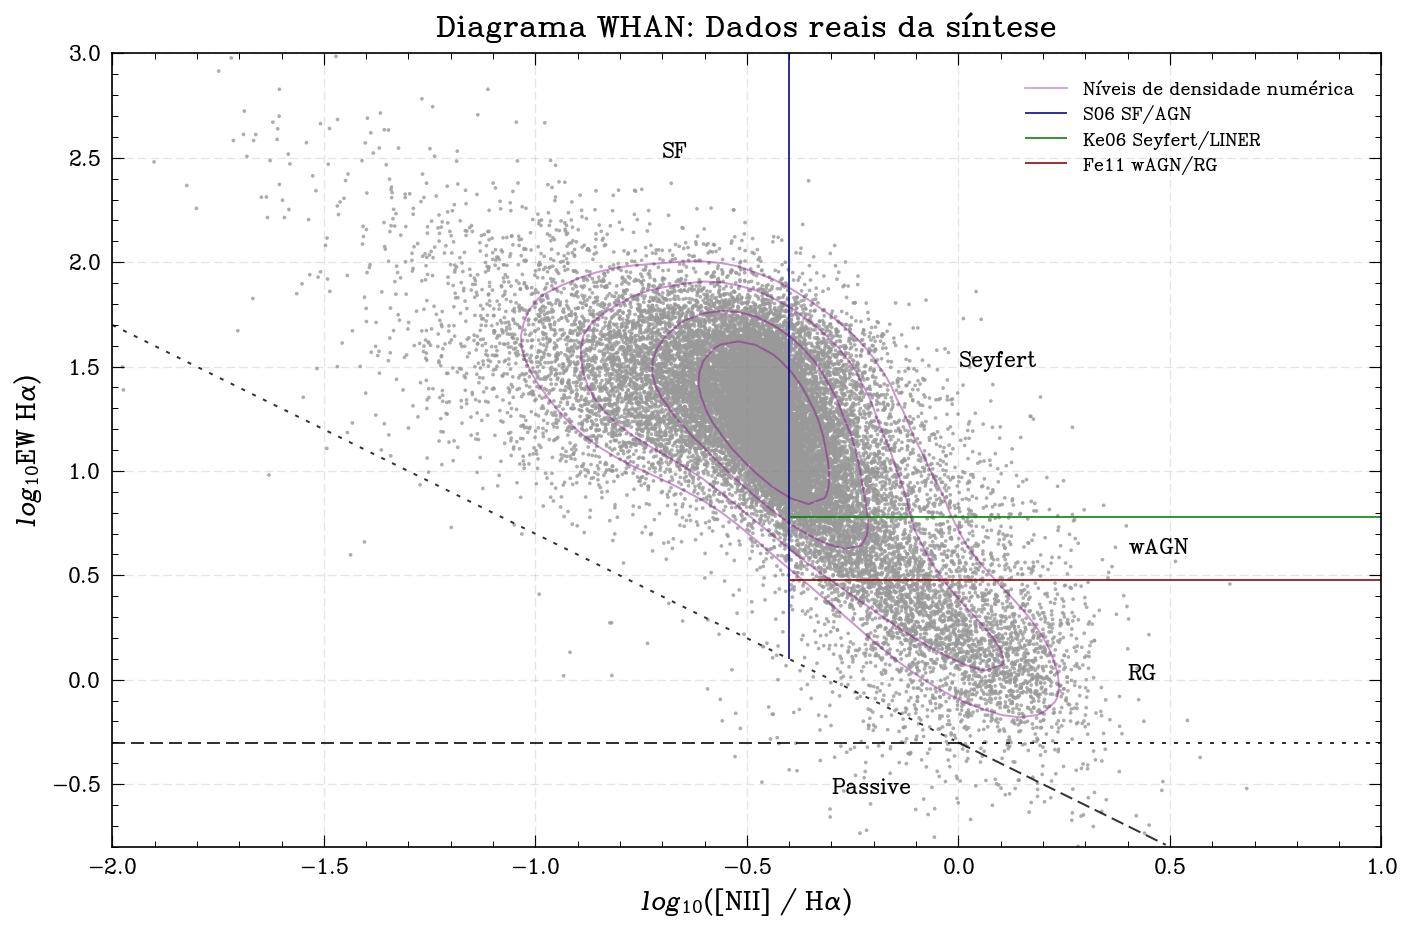

In [19]:
p.show_whan(dados_)